
# Spearman correlation between two Netcdf datasets

In [1]:
import warnings; warnings.filterwarnings(action='ignore')
%matplotlib inline
#for Netcdf manipulation
import xarray as xr
from netCDF4 import Dataset
import netCDF4 as nc

#for array manipulation
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Grouper

#for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap # plots maps
import cmocean

#for interpolation
from scipy.spatial import cKDTree

In [2]:
                                                # # Spearman correlation between two Netcdf datasets # #
# # Reading in both SIT and SIA files that were interpolated for the 316 x 332 grid

                            ##### XARRAY #####
sia_file = '/Users/fridaperez/Developer/repos/local_repo/Area_SH_Filled-316x332.nc'  # prepping path for xr
sit_file = '/Users/fridaperez/Developer/repos/local_repo/SIT_25000/SIT_SH_Filled-316x332.nc'

data_sia = xr.open_dataset(sia_file) # opening sit for xarray
data_sit= xr.open_dataset(sit_file)

In [3]:
sit_nc = nc.Dataset('/Users/fridaperez/Developer/repos/local_repo/SIT_25000/SIT_SH_Filled-316x332.nc')
#reading in SIT variables 02-18
time = sit_nc.variables['time'][:]  #sit time
lat=sit_nc.variables['latitude'][:]
lon=sit_nc.variables['longitude'][:]
sit=sit_nc.variables['SIT'][:,:,:]
sit_y=sit_nc.variables['ygrid'][:]
sit_x=sit_nc.variables['xgrid'][:]

sia_nc = nc.Dataset('/Users/fridaperez/Developer/repos/local_repo/Area_SH_Filled-316x332.nc')
#reading in SIA variables 02-18
time = sia_nc.variables['time'][:]  #sit time
#lat_sia=sia_nc.variables['latitude'][:]
#lon_sia=sia_nc.variables['longitude'][:]
sia=sia_nc.variables['__xarray_dataarray_variable__'][:,:,:]
#sia_y=sia_nc.variables['ygrid'][:]
#sia_x=sia_nc.variables['xgrid'][:]

## Now we want to correlate by month 

### SIA

In [4]:
# Use .groupby('time.month') to organize the data into months
# then use .groups to extract the indices for each month
month_idxs=data_sia.groupby('time.month').groups
# Extract the time indices corresponding to all the months 
may_idxs=month_idxs[5]
jun_idxs=month_idxs[6]
jul_idxs=month_idxs[7]
aug_idxs=month_idxs[8]
sep_idxs=month_idxs[9]
octo_idxs=month_idxs[10]

In [5]:
# Extract months by selecting
# the relevant indices
gs_may=data_sia.isel(time=may_idxs)
gs_jun=data_sia.isel(time=jun_idxs)
gs_jul=data_sia.isel(time=jul_idxs)
gs_aug=data_sia.isel(time=aug_idxs)
gs_sep=data_sia.isel(time=sep_idxs)
gs_octo=data_sia.isel(time=octo_idxs)

In [6]:
gs_may

<xarray.Dataset>
Dimensions:                        (time: 16, xgrid: 316, ygrid: 332)
Coordinates:
  * time                           (time) datetime64[ns] 2003-05-01 ... 2018-...
    longitude                      (ygrid, xgrid) float64 ...
    latitude                       (ygrid, xgrid) float64 ...
Dimensions without coordinates: xgrid, ygrid
Data variables:
    __xarray_dataarray_variable__  (time, ygrid, xgrid) float64 ...

### SIT

In [7]:
# Use .groupby('time.month') to organize the data into months
# then use .groups to extract the indices for each month
month_idxss=data_sit.groupby('time.month').groups
# Extract the time indices corresponding to all the months 
may_idxss=month_idxss[5]
jun_idxss=month_idxss[6]
jul_idxss=month_idxss[7]
aug_idxss=month_idxss[8]
sep_idxss=month_idxss[9]
octo_idxss=month_idxss[10]

In [8]:
# Extract months by selecting
# the relevant indices
gst_may=data_sit.isel(time=may_idxss)
gst_jun=data_sit.isel(time=jun_idxss)
gst_jul=data_sit.isel(time=jul_idxss)
gst_aug=data_sit.isel(time=aug_idxss)
gst_sep=data_sit.isel(time=sep_idxss)
gst_octo=data_sit.isel(time=octo_idxss)

## May

In [9]:
from scipy import stats
import numpy as np

#Spearman correlation between two datasets for each grid point
corr_spearman_SIA_may = np.zeros((gs_may['__xarray_dataarray_variable__'].shape[1],gs_may['__xarray_dataarray_variable__'].shape[2]),dtype=float)
for ni in range(0,gs_may['__xarray_dataarray_variable__'].shape[2]):   # loop over longitudes
    for nj in range(0, gs_may['__xarray_dataarray_variable__'].shape[1]):  # loop over latitudes
        r, p = stats.spearmanr(gs_may.isel(ygrid=[nj], xgrid=[ni]).__xarray_dataarray_variable__.values[:,0,0] ,
                               gst_may.isel(ygrid=[nj], xgrid=[ni]).SIT.values[:,0,0])
        if p >= 0.1 :
            corr_spearman_SIA_may[nj,ni] = p
        else:
            corr_spearman_SIA_may[nj,ni] = r

In [10]:
# # Making a netcdf file for May 
May_corr = xr.Dataset( coords={'longitude' : (['ygrid', 'xgrid'], data_sit.longitude),
                                                      'latitude' : (['ygrid', 'xgrid'], data_sit.latitude)})
May_corr["spearmay"] = (['latitude', 'longitude'],  corr_spearman_SIA_may)

#saving netcdf file 
May_corr.to_netcdf('/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/maycorr.nc')

In [11]:
spear_may = '/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/maycorr.nc'
maycor = xr.open_dataset(spear_may) # opening sit for xarray 

In [12]:
spear_m=maycor.spearmay

In [13]:
# m = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
# x, y = m(lon,lat)
# fig = plt.figure(figsize=(12,12))
# m.fillcontinents(color='white',lake_color='white')
# m.drawcoastlines()
# m.drawparallels(np.arange(-80.,0.,20.))
# m.drawmeridians(np.arange(-180.,181.,20.))
# m.drawmapboundary(fill_color='lightblue')
# cmap0 = plt.cm.get_cmap('jet', 11)
# m.contourf(x,y,spear_m,40,cmap=cmap0,levels=[-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
# transform=ccrs.SouthPolarStereo()
# plt.colorbar(label=u'\n Envisat-NOAA/NSIDC Correlation - Resolution: 25km')
# plt.title(u'Spearman Correlation Monthly Sea ice concentration and sea ice thickness \n May 2003-2018 ')
# #plt.savefig('spear_may.png', dpi=100)

## June

In [14]:
from scipy import stats
import numpy as np

# Spearman correlation between two datasets for each grid point
corr_spearman_SIA_jun = np.zeros((gs_jun['__xarray_dataarray_variable__'].shape[1],gs_jun['__xarray_dataarray_variable__'].shape[2]),dtype=float)
for ni in range(0,gs_jun['__xarray_dataarray_variable__'].shape[2]):   # loop over longitudes
    for nj in range(0, gs_jun['__xarray_dataarray_variable__'].shape[1]):  # loop over latitudes
        r, p = stats.spearmanr(gs_jun.isel(ygrid=[nj], xgrid=[ni]).__xarray_dataarray_variable__.values[:,0,0] ,
                               gst_jun.isel(ygrid=[nj], xgrid=[ni]).SIT.values[:,0,0] )
        if p >= 0.1 :
            corr_spearman_SIA_jun[nj,ni] = p
        else:
            corr_spearman_SIA_jun[nj,ni] = r

In [15]:
# Making a netcdf file for June
June_corr = xr.Dataset( coords={'longitude' : (['ygrid', 'xgrid'], data_sit.longitude),
                                                       'latitude' : (['ygrid', 'xgrid'], data_sit.latitude)})

June_corr["spearjune"] = (['latitude', 'longitude'],  corr_spearman_SIA_jun)

#saving netcdf file 
June_corr.to_netcdf('/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/juncorr.nc')

In [16]:
spear_jun = '/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/juncorr.nc'
juncor = xr.open_dataset(spear_jun) # opening sit for xarray 

In [17]:
spear_jn=juncor.spearjune

In [18]:
# m = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
# x, y = m(lon,lat)
# fig = plt.figure(figsize=(12,12))
# m.fillcontinents(color='white',lake_color='white')
# m.drawcoastlines()
# m.drawparallels(np.arange(-80.,0.,20.))
# m.drawmeridians(np.arange(-180.,181.,20.))
# m.drawmapboundary(fill_color='skyblue')
# cmap0 = plt.cm.get_cmap('jet', 11)
# m.contourf(x,y,spear_jn,40,cmap=cmap0,levels=[-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
# transform=ccrs.SouthPolarStereo()
# plt.colorbar(label=u'\n Envisat-NOAA/NSIDC Correlation - Resolution: 25km')
# plt.title(u'Spearman Correlation Monthly sea ice concentration and sea ice thickness \n June 2003-2018 ')
# #plt.savefig('spear_june.png', dpi=100)

## July

In [19]:
from scipy import stats
import numpy as np

# Spearman correlation between two datasets for each grid point
corr_spearman_SIA_jul = np.zeros((gs_jul['__xarray_dataarray_variable__'].shape[1],gs_jul['__xarray_dataarray_variable__'].shape[2]),dtype=float)
for ni in range(0,gs_jul['__xarray_dataarray_variable__'].shape[2]):   # loop over longitudes
    for nj in range(0, gs_jul['__xarray_dataarray_variable__'].shape[1]):  # loop over latitudes
        r, p = stats.spearmanr(gs_jul.isel(ygrid=[nj], xgrid=[ni]).__xarray_dataarray_variable__.values[:,0,0] ,
                               gst_jul.isel(ygrid=[nj], xgrid=[ni]).SIT.values[:,0,0] )
        if p >= 0.1 :
            corr_spearman_SIA_jul[nj,ni] = p
        else:
            corr_spearman_SIA_jul[nj,ni] = r

In [20]:
# Making a netcdf file for June
July_corr = xr.Dataset( coords={'longitude' : (['ygrid', 'xgrid'], data_sit.longitude),
                                                       'latitude' : (['ygrid', 'xgrid'], data_sit.latitude)})

July_corr["spearjuly"] = (['latitude', 'longitude'],  corr_spearman_SIA_jun)

#saving netcdf file 
July_corr.to_netcdf('/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/julcorr.nc')

In [21]:
spear_jul = '/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/julcorr.nc'
julcor = xr.open_dataset(spear_jul) # opening sit for xarray 

In [22]:
spear_jl=julcor.spearjuly

In [23]:
# m = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
# x, y = m(lon,lat)
# fig = plt.figure(figsize=(12,12))
# m.fillcontinents(color='white',lake_color='white')
# m.drawcoastlines()
# m.drawparallels(np.arange(-80.,0.,20.))
# m.drawmeridians(np.arange(-180.,181.,20.))
# m.drawmapboundary(fill_color='skyblue')
# cmap0 = plt.cm.get_cmap('jet', 11)
# m.contourf(x,y,spear_jl,40,cmap=cmap0,levels=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
# transform=ccrs.SouthPolarStereo()
# plt.colorbar(label=u'\n Envisat-NOAA/NSIDC Correlation - Resolution: 25km')
# plt.title(u'Spearman Correlation Monthly Sea Ice Concentration and Sea Ice Thickness \n July 2003-2011 ')
# #plt.savefig('spear_july.png', dpi=100)

## August

In [24]:
from scipy import stats
import numpy as np

# Spearman correlation between two datasets for each grid point
corr_spearman_SIA_aug = np.zeros((gs_aug['__xarray_dataarray_variable__'].shape[1],gs_aug['__xarray_dataarray_variable__'].shape[2]),dtype=float)
for ni in range(0,gs_aug['__xarray_dataarray_variable__'].shape[2]):   # loop over longitudes
    for nj in range(0, gs_aug['__xarray_dataarray_variable__'].shape[1]):  # loop over latitudes
        r, p = stats.spearmanr(gs_aug.isel(ygrid=[nj], xgrid=[ni]).__xarray_dataarray_variable__.values[:,0,0] ,
                               gst_aug.isel(ygrid=[nj], xgrid=[ni]).SIT.values[:,0,0] )
        if p >= 0.1 :
            corr_spearman_SIA_aug[nj,ni] = p
        else:
            corr_spearman_SIA_aug[nj,ni] = r

In [25]:
# Making a netcdf file for August
Aug_corr = xr.Dataset( coords={'longitude' : (['ygrid', 'xgrid'], data_sit.longitude),
                                                       'latitude' : (['ygrid', 'xgrid'], data_sit.latitude)})

Aug_corr["spearaug"] = (['latitude', 'longitude'],  corr_spearman_SIA_aug)

#saving netcdf file 
Aug_corr.to_netcdf('/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/augcorr.nc')

In [26]:
spear_aug = '/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/augcorr.nc'
augcor = xr.open_dataset(spear_aug) # opening sit for xarray 

In [27]:
spear_aug=augcor.spearaug

In [28]:
# m = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
# x, y = m(lon,lat)
# fig = plt.figure(figsize=(12,12))
# m.fillcontinents(color='white',lake_color='white')
# m.drawcoastlines()
# m.drawparallels(np.arange(-80.,0.,20.))
# m.drawmeridians(np.arange(-180.,181.,20.))
# m.drawmapboundary(fill_color='skyblue')
# cmap0 = plt.cm.get_cmap('jet', 11)
# m.contourf(x,y,spear_aug,40,cmap=cmap0,levels=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
# transform=ccrs.SouthPolarStereo()
# plt.colorbar(label=u'\n Envisat-NOAA/NSIDC Correlation - Resolution: 25km')
# plt.title(u'Spearman Correlation Monthly Sea Ice Concentration and Sea Ice Thickness \n August 2003-2011 ')
#plt.savefig('spear_aug.png', dpi=100)

## September

In [29]:
from scipy import stats
import numpy as np

# Spearman correlation between two datasets for each grid point
corr_spearman_SIA_sep = np.zeros((gs_sep['__xarray_dataarray_variable__'].shape[1],gs_sep['__xarray_dataarray_variable__'].shape[2]),dtype=float)
for ni in range(0,gs_sep['__xarray_dataarray_variable__'].shape[2]):   # loop over longitudes
    for nj in range(0, gs_sep['__xarray_dataarray_variable__'].shape[1]):  # loop over latitudes
        r, p = stats.spearmanr(gs_sep.isel(ygrid=[nj], xgrid=[ni]).__xarray_dataarray_variable__.values[:,0,0] ,
                               gst_sep.isel(ygrid=[nj], xgrid=[ni]).SIT.values[:,0,0] )
        if p >= 0.1 :
            corr_spearman_SIA_sep[nj,ni] = p
        else:
            corr_spearman_SIA_sep[nj,ni] = r

In [30]:
# Making a netcdf file for sep
Sep_corr = xr.Dataset( coords={'longitude' : (['ygrid', 'xgrid'], data_sit.longitude),
                                                       'latitude' : (['ygrid', 'xgrid'], data_sit.latitude)})

Sep_corr["spearsep"] = (['latitude', 'longitude'],  corr_spearman_SIA_sep)

#saving netcdf file 
Sep_corr.to_netcdf('/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/sepcorr.nc')

In [31]:
spear_sep = '/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/sepcorr.nc'
sepcor = xr.open_dataset(spear_sep) # opening sit for xarray 

In [32]:
spear_sep=sepcor.spearsep

In [33]:
# m = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
# x, y = m(lon,lat)
# fig = plt.figure(figsize=(12,12))
# m.fillcontinents(color='white',lake_color='white')
# m.drawcoastlines()
# m.drawparallels(np.arange(-80.,0.,20.))
# m.drawmeridians(np.arange(-180.,181.,20.))
# m.drawmapboundary(fill_color='skyblue')
# cmap0 = plt.cm.get_cmap('jet', 11)
# m.contourf(x,y,spear_sep,40,cmap=cmap0,levels=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
# transform=ccrs.SouthPolarStereo()
# plt.colorbar(label=u'\n Envisat-NOAA/NSIDC Correlation - Resolution: 25km')
# plt.title(u'Spearman Correlation Monthly Sea Ice Concentration and Sea Ice Thickness \n September 2003-2018 ')
# #plt.savefig('spear_sep.png', dpi=100)

## October

In [34]:
from scipy import stats
import numpy as np

# Spearman correlation between two datasets for each grid point
corr_spearman_SIA_oct = np.zeros((gs_octo['__xarray_dataarray_variable__'].shape[1],gs_octo['__xarray_dataarray_variable__'].shape[2]),dtype=float)
for ni in range(0,gs_octo['__xarray_dataarray_variable__'].shape[2]):   # loop over longitudes
    for nj in range(0, gs_octo['__xarray_dataarray_variable__'].shape[1]):  # loop over latitudes
        r, p = stats.spearmanr(gs_octo.isel(ygrid=[nj], xgrid=[ni]).__xarray_dataarray_variable__.values[:,0,0] ,
                               gst_octo.isel(ygrid=[nj], xgrid=[ni]).SIT.values[:,0,0] )
        if p >= 0.1 :
            corr_spearman_SIA_oct[nj,ni] = p
        else:
            corr_spearman_SIA_oct[nj,ni] = r

In [35]:
# Making a netcdf file for sep
Oct_corr = xr.Dataset( coords={'longitude' : (['ygrid', 'xgrid'], data_sit.longitude),
                                                       'latitude' : (['ygrid', 'xgrid'], data_sit.latitude)})

Oct_corr["spearoct"] = (['latitude', 'longitude'],  corr_spearman_SIA_oct)

#saving netcdf file 
Oct_corr.to_netcdf('/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/octcorr.nc')

In [36]:
spear_oct = '/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/octcorr.nc'
octcor = xr.open_dataset(spear_oct) # opening sit for xarray 

In [37]:
spear_oct=octcor.spearoct

In [38]:
# m = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
# x, y = m(lon,lat)
# fig = plt.figure(figsize=(12,12))
# m.fillcontinents(color='white',lake_color='white')
# m.drawcoastlines()
# m.drawparallels(np.arange(-80.,0.,20.))
# m.drawmeridians(np.arange(-180.,181.,20.))
# m.drawmapboundary(fill_color='skyblue')
# cmap0 = plt.cm.get_cmap('jet', 11)
# m.contourf(x,y,spear_oct,40,cmap=cmap0,levels=[-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
# transform=ccrs.SouthPolarStereo()
# plt.colorbar(label=u'\n Envisat-NOAA/NSIDC Correlation - Resolution: 25km')
# plt.title(u'Spearman Correlation Monthly Sea Ice Concentration and Sea Ice Thickness \n October 2003-2018 ')
#plt.savefig('spear_oct.png', dpi=100)

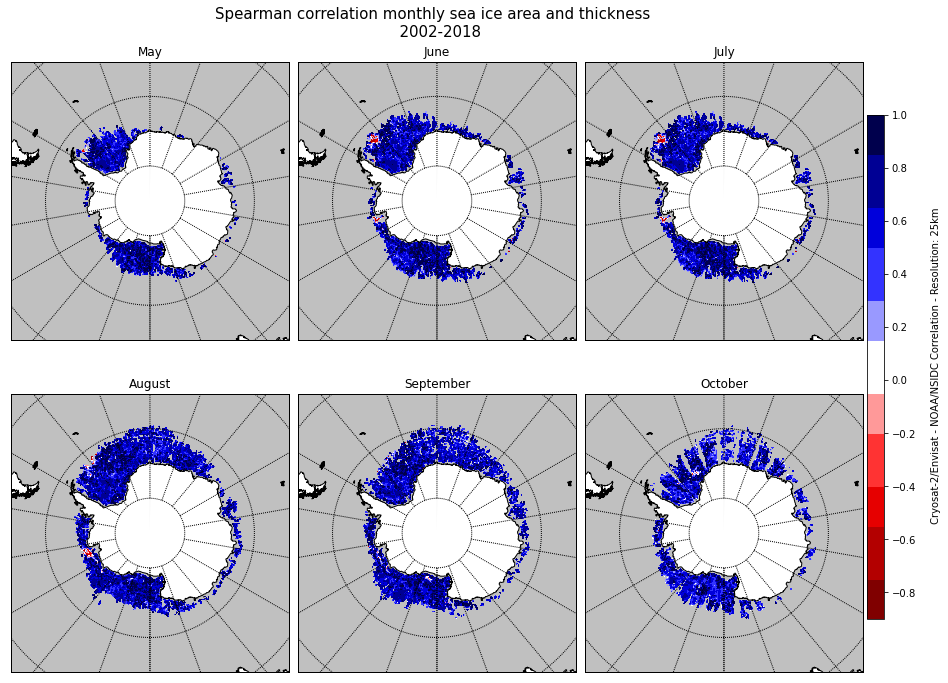

In [48]:
#import matplotlib
#matplotlib.use('PS')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap # plots maps

fig = plt.figure(figsize=[12,10])

#May
ax = fig.add_subplot(231)
ax.set_title("May")
m = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
x, y = m(lon, lat)
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,0.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='silver')
cmap0 = plt.cm.get_cmap('seismic_r', 11)
clr2=m.contourf(x,y,spear_m,40,cmap=cmap0)
transform=ccrs.SouthPolarStereo()

#June
ax = fig.add_subplot(232)
ax.set_title("June")

j = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
x, y = j(lon, lat)
j.fillcontinents(color='white',lake_color='white')
j.drawcoastlines()
j.drawparallels(np.arange(-80.,0.,20.))
j.drawmeridians(np.arange(-180.,181.,20.))
j.drawmapboundary(fill_color='silver')
cmap0 = plt.cm.get_cmap('seismic_r', 11)
j.contourf(x,y,spear_jn,40,cmap=cmap0)
transform=ccrs.SouthPolarStereo()

#July
ax = fig.add_subplot(233)
ax.set_title("July")
jj = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
x, y = jj(lon, lat)
jj.fillcontinents(color='white',lake_color='white')
jj.drawcoastlines()
jj.drawparallels(np.arange(-80.,0.,20.))
jj.drawmeridians(np.arange(-180.,181.,20.))
jj.drawmapboundary(fill_color='silver')
cmap0 = plt.cm.get_cmap('seismic_r', 11)
jj.contourf(x,y,spear_jl,40,cmap=cmap0)
transform=ccrs.SouthPolarStereo()

#August
ax = fig.add_subplot(234)
ax.set_title("August")
a = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
x, y = a(lon, lat)
a.fillcontinents(color='white',lake_color='white')
a.drawcoastlines()
a.drawparallels(np.arange(-80.,0.,20.))
a.drawmeridians(np.arange(-180.,181.,20.))
a.drawmapboundary(fill_color='silver')
cmap0 = plt.cm.get_cmap('seismic_r', 11)
a.contourf(x,y,spear_aug,40,cmap=cmap0)
transform=ccrs.SouthPolarStereo()

#September
ax = fig.add_subplot(235)
ax.set_title("September")
s = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
x, y = s(lon, lat)
s.fillcontinents(color='white',lake_color='white')
s.drawcoastlines()
s.drawparallels(np.arange(-80.,0.,20.))
s.drawmeridians(np.arange(-180.,181.,20.))
s.drawmapboundary(fill_color='silver')
cmap0 = plt.cm.get_cmap('seismic_r', 11)
s.contourf(x,y,spear_sep,40,cmap=cmap0)
transform=ccrs.SouthPolarStereo()

#October
ax = fig.add_subplot(236)
ax.set_title("October")
oc = Basemap(projection= 'spaeqd',boundinglat=-50,lon_0=-180,resolution='l')
x, y = oc(lon, lat)
oc.fillcontinents(color='white',lake_color='white')
oc.drawcoastlines()
oc.drawparallels(np.arange(-80.,0.,20.))
oc.drawmeridians(np.arange(-180.,181.,20.))
oc.drawmapboundary(fill_color='silver')
cmap0 = plt.cm.get_cmap('seismic_r', 11)
oc.contourf(x,y,spear_oct,40,cmap=cmap0)
transform=ccrs.SouthPolarStereo()

fig.suptitle(u'Spearman correlation monthly sea ice area and thickness \n  2002-2018', fontsize=15, y=1)
plt.subplots_adjust(wspace=0.05, hspace=0.05, right=0.8)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#cbar_ax = fig.add_axes([-0.05, 0.15, 0.02, 0.7])
cbar_axx = fig.add_axes([1, 0.15, 0.02, 0.7])

fig.colorbar(clr2,cax=cbar_axx,label= u'\n Cryosat-2/Envisat - NOAA/NSIDC Correlation - Resolution: 25km')
#fig.colorbar(clr1, cax=cbar_axx,label= 'SIT (m) mean')

# saving figure #
plt.savefig('/Users/fridaperez/Developer/repos/local_repo/SpearmanCorrs/month_spear_SIA_SIT.png', dpi=300, bbox_inches='tight')

# showing figure # 
plt.show()
#levels=[-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]